In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'

In [2]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), 512, dtype = torch.float32)
    inputs = torch.zeros(len(files), 10, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass
    return inputs, labels
            

In [3]:
inputs,labels = read_data('/home/slaskina/simulations')

In [4]:

# Creating data indices for training and validation splits:
dataset_size = len(labels)
indices = list(range(dataset_size))
test_size = 0.1
val_size = 0.2
test_split = int(np.floor(test_size * dataset_size))
val_split = int(np.floor(val_size * dataset_size))
np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
batch_size=128

In [5]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset( labels, inputs), batch_size=batch_size, drop_last=True, sampler = val_sampler)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(labels, inputs), batch_size=batch_size, drop_last=True, sampler = train_sampler)

In [153]:
class ForwardScattering(nn.Module):
    def __init__(self, in_dim, out_dim) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_dim, 1024)
        self.conv1 = nn.Conv1d(in_channels = 512,out_channels =  512, kernel_size = 5, padding = 2)
        self.conv2 = nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3)
        self.linear_out = nn.Linear(128,out_dim)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.linear_out(x)
        return x

In [132]:
class ForwardScattering(nn.Module):
    def __init__(self, in_dim, out_dim) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_dim, 2048)
        self.linear_middle = nn.Linear(2048,2048)
        self.linear_out = nn.Linear(2048,out_dim)
    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for _ in range(5):
            x = F.relu(self.linear_middle(x))
        x = self.linear_out(x)
        return x

In [163]:
model = ForwardScattering(512,10).to(device)
print(model)

ForwardScattering(
  (linear_in): Linear(in_features=512, out_features=1024, bias=True)
  (conv1): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(512, 128, kernel_size=(11,), stride=(3,), padding=(5,))
  (linear_out): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [164]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [169]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.reshape(len(X), -1, 1).to(device), y.to(device)#
        # Compute prediction and loss
        pred = model(X).reshape(-1,10)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch ==size:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",end = '')


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.reshape(len(X), -1, 1).to(device), y.to(device)
            pred = model(X).reshape(-1,10)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    print(f"Avg loss: {test_loss:>8f} \n",end = '')

In [170]:

epochs = 2000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------", end = '')
    train_loop(train_loader, model, loss, optimizer)
    test_loop(test_loader, model, loss)
print("Done!")

Epoch 1
-------------------------------Avg loss: 0.166748 
Epoch 2
-------------------------------Avg loss: 0.167477 
Epoch 3
-------------------------------Avg loss: 0.166454 
Epoch 4
-------------------------------Avg loss: 0.167171 
Epoch 5
-------------------------------Avg loss: 0.166437 
Epoch 6
-------------------------------Avg loss: 0.166428 
Epoch 7
-------------------------------Avg loss: 0.165669 
Epoch 8
-------------------------------Avg loss: 0.166172 
Epoch 9
-------------------------------Avg loss: 0.165404 
Epoch 10
-------------------------------Avg loss: 0.165842 
Epoch 11
-------------------------------Avg loss: 0.164335 
Epoch 12
-------------------------------Avg loss: 0.166050 
Epoch 13
-------------------------------Avg loss: 0.165711 
Epoch 14
-------------------------------Avg loss: 0.164909 
Epoch 15
-------------------------------Avg loss: 0.165381 
Epoch 16
-------------------------------Avg loss: 0.164957 
Epoch 17
-------------------------------Avg loss:

In [171]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd

In [172]:
def create_table_from_outcome(pred, sampled_inputs):
    df = pd.DataFrame(columns = ['true_shape', 'pred_shape', 'radius','pred_radius'], index = [])
    df['true_shape'] = sampled_inputs[:,:3].argmax(axis=1)
    df['pred_shape'] = pred[:,:3].argmax(axis=1)
    df['radius'] = np.take_along_axis(sampled_inputs[:,3:6],df.true_shape.values.reshape(-1,1), axis=1)
    df['pred_radius'] = np.take_along_axis(pred[:,3:6],df.pred_shape.values.reshape(-1,1), axis=1)
    df['radius_pd'] = sampled_inputs[:,6]
    df['pred_radius_pd'] = pred[:,6]
    df['length'] = sampled_inputs[:,7]
    df['pred_length'] = np.where(df.pred_shape.values ==2, pred[:,7], 0) # only those identified as cylinder should have lengh and pd_length
    df['length_pd'] = sampled_inputs[:,8]
    df['pred_length_pd'] = np.where(df.pred_shape.values ==2, pred[:,8], 0)
    df['volfraction'] = sampled_inputs[:,9]
    df['pred_volfraction'] = np.where(df.pred_shape.values ==1, pred[:,9], 0)
    return df

In [175]:
def make_prediction(labels, model):
    return model(labels.reshape(len(labels), 512, 1))#


In [176]:
predicted_features = make_prediction(labels[test_indices], model.to('cpu')).detach().numpy()

In [177]:
df = create_table_from_outcome(predicted_features, inputs[test_indices])

In [178]:
pd.DataFrame(predicted_features)

,0,1,2,3,4,5,6,7,8,9
0,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
1,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
2,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
3,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
4,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
...,...,...,...,...,...,...,...,...,...,...
1495,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
1496,0.326062,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
1497,0.326061,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215
1498,0.326061,0.33103,0.323283,0.067347,0.068099,0.064936,0.052769,0.424123,0.029895,0.050215


In [179]:
def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

In [180]:
def outcomes(df, data_name):
    print('Accuracy is {0:.2%}'.format((df.true_shape == df.pred_shape).sum()/len(df)))
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    shapes = ['sphere', 'hardsphere', 'cylinder']
    # shape classified correctly
    correct = [((df.true_shape == 0) & (df.pred_shape == 0)).sum(),((df.true_shape == 1) & (df.pred_shape == 1)).sum(),((df.true_shape == 2) & (df.pred_shape == 2)).sum()]
    wrong = [((df.true_shape == 0) & (df.pred_shape != 0)).sum(),((df.true_shape == 1) & (df.pred_shape != 1)).sum(),((df.true_shape == 2) & (df.pred_shape != 2)).sum()]
    correct = [correct[i]/(correct[i]+ wrong[i])*100 for i in range(len(correct))]
    wrong = [100-correct[i] for i in range(len(wrong))]
    ax = axes[0,0]
    ax.bar(shapes, correct, width=0.35, label='correct', color = 'peachpuff')
    ax.bar(shapes, wrong, width=0.35,bottom=correct, label='misclassified', color = 'plum')
    ax.set_ylabel('correct predictions, %')
    ax.set_title('Shapes predictions')
    ax.text(-0.05, 5, 'correct', rotation = 90)
    ax.text(0.95, 5, 'correct', rotation = 90)
    ax.text(1.95, 5, 'correct', rotation = 90)
    
    ax.text(-0.05, 65, 'misclassified', rotation = 90)
    ax.text(0.95, 65, 'misclassified', rotation = 90)
    ax.text(1.95, 65, 'misclassified', rotation = 90)

    # radius of a correctly identified shapes
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
      
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

    print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
    print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
    print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
        (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))
    #stacked df to create violinplots
    df_stacked = df[df.true_shape ==df.pred_shape].drop(columns = ['pred_shape']).set_index('true_shape').stack().reset_index().rename(columns = {'level_1':'feature', 0:'value'})
    df_stacked.loc[df_stacked.true_shape == 0, 'true_shape'] = "sphere"
    df_stacked.loc[df_stacked.true_shape == 1, 'true_shape'] = "hardsphere"
    df_stacked.loc[df_stacked.true_shape == 2, 'true_shape'] = "cylinder"

    ax = axes[0,1]
    data = df_stacked[(df_stacked.feature == 'radius')|(df_stacked.feature == 'pred_radius')]
    data.loc[data.feature == 'radius', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius distribution for correct shapes')
    ax.set_ylabel("radius, nm")
    ax.set_xlabel("")
    ax.legend()

    ax = axes[0,2]
    data = df_stacked[(df_stacked.feature == 'radius_pd')|(df_stacked.feature == 'pred_radius_pd')]
    data.loc[data.feature == 'radius_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius polidispersity distribution\nfor correct shapes')
    ax.legend()
    ax.set_ylabel("radius pd")
    ax.set_xlabel("")

    # length
    df_stacked = df.set_index(['true_shape', 'pred_shape']).stack().reset_index().rename(columns = {'level_2':'feature', 0:'value'}).assign(y=1)

    ax = axes[1,0]
    data = df_stacked[((df_stacked.feature == 'length')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature",split = True, ax=ax, palette=['peachpuff', 'plum'] )
    ax.set_title('Length distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length, nm")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 4.2, "sampled")
    ax.text(0.2, 4.2, "predicted")
    ax.set_ylim([-.5,6])

    ax = axes[1,1]
    data = df_stacked[((df_stacked.feature == 'length_pd')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length_pd')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False),  x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Length polidispersity distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length pd")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.25, "sampled")
    ax.text(0.2, 0.25, "predicted")
    ax.set_ylim([-0.05, 0.35])

    ax = axes[1,2]
    data = df_stacked[((df_stacked.feature == 'volfraction')&(df_stacked.true_shape ==1))|((df_stacked.feature == 'pred_volfraction')&(df_stacked.pred_shape == 1))]
    data.loc[data.feature == 'volfraction', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_volfraction', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Volume fraction distribution of hardsphere')
    ax.set_xlabel("hardsphere")
    ax.set_ylabel("volumefraction")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.5, "sampled")
    ax.text(0.2, 0.5, "predicted")
    ax.set_ylim([-0.1, 0.7])

    plt.suptitle('{d} Data'.format(d = data_name))

In [181]:
df

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,1,0.014534,0.068099,0.037837,0.052769,0.000000,0.0,0.000000,0.0,0.20,0.050215
1,2,1,0.127441,0.068099,0.041223,0.052769,0.332047,0.0,0.068415,0.0,0.00,0.050215
2,2,1,0.043445,0.068099,0.065933,0.052769,2.211643,0.0,0.073377,0.0,0.00,0.050215
3,2,1,0.032580,0.068099,0.007176,0.052769,2.162128,0.0,0.101232,0.0,0.00,0.050215
4,1,1,0.115862,0.068099,0.012090,0.052769,0.000000,0.0,0.000000,0.0,0.05,0.050215
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,0.424327,0.068099,0.051840,0.052769,0.000000,0.0,0.000000,0.0,0.30,0.050215
1496,0,1,0.119943,0.068099,0.059004,0.052769,0.000000,0.0,0.000000,0.0,0.00,0.050215
1497,2,1,0.345031,0.068099,0.034487,0.052769,0.348878,0.0,0.016987,0.0,0.00,0.050215
1498,0,1,0.269215,0.068099,0.021152,0.052769,0.000000,0.0,0.000000,0.0,0.00,0.050215


Accuracy is 32.40%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0292 and cylinder: inf
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: 0.0008 and cylinder: inf
MSE for cylinder length for correctly identified instances: inf
MSE for cylinder length polydispersity for correctly identified instances: inf
MSE for cylinder length for correctly identified instances: 0.0204


ValueError: There must be exactly two hue levels to use `split`.'

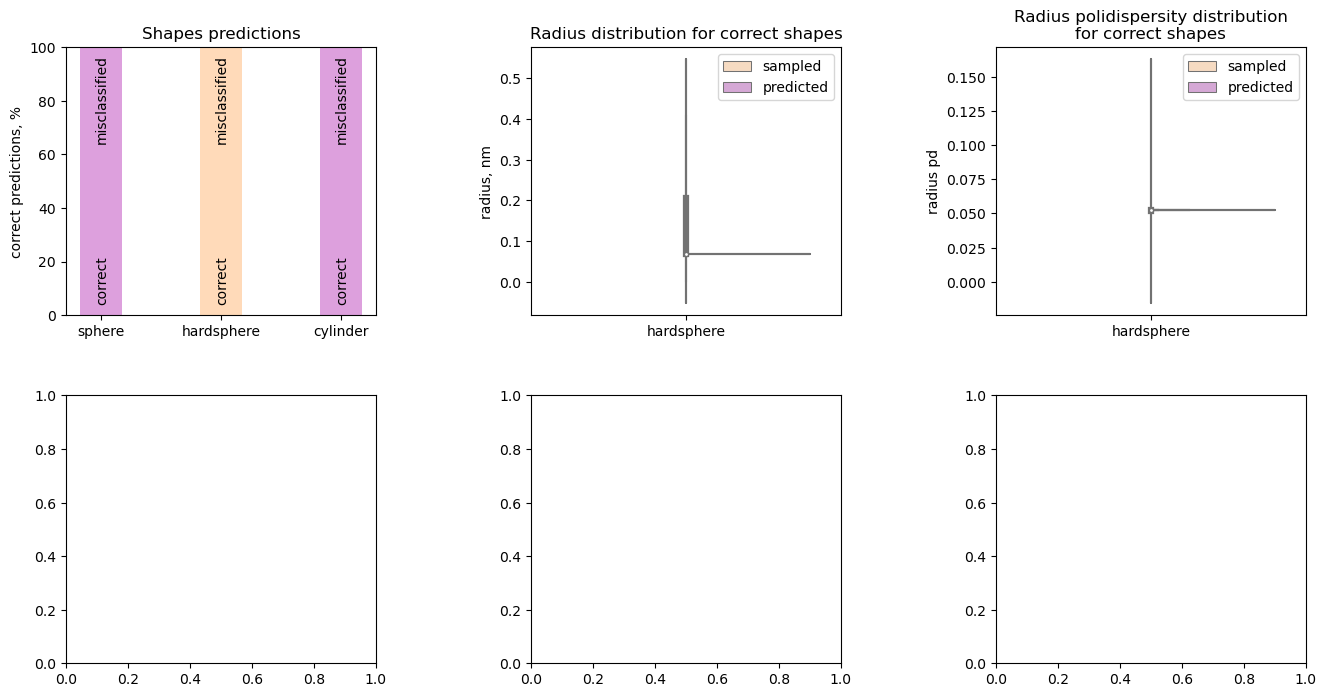

In [182]:
outcomes(df, 'test')